# **NLP Over a SXSW Twitter Data Set**

## Package and Data Import

*Package Imports*

In [217]:
### Packages to Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import warnings
nltk.download('wordnet')
nltk.download('vader_lexicon')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jake\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [218]:
pip install wordcloud

In [219]:
from wordcloud import WordCloud

*Importing CSV File*

In [220]:
### Import Data and Change Column Names

df = pd.read_csv("data/tweets.csv")
df.columns = ['text', 'device', 'emotion']

## Pre-Data Cleaning Column Addition

**Create column that counts the amount of mentions in a tweet**

In [221]:
### Creating a column that counts the amount of mentions in each tweet

df['mentions'] = df.text.str.count('@')

**Create a column that counts the amount of links in a tweet**

*We are also considering anything with '.com', 'http', 'bit.ly', '.co', and '{link}' as a link*

In [222]:
df['links'] = 0

url_like_strings = ['{link}', '.com', 'http', 'bit.ly', '.co']
for s in url_like_strings:
    df['links'] = df.links + list(map(lambda x: str(x).count(s), df['text']))

## Data Cleaning

**Dropping non-significant values and rows**

In [223]:
### Dropping 'I can't tell' and 'Other' rows

df = df[df['emotion'] != "I can't tell"]

### Dropping blank 'text' rows

df = df.dropna(subset=['text'])

**Creating functions that clean the text data**

In [224]:
### Creating a function that makes all text lowercase for further analysis

def lower_case(text):
    text = text.lower()
    return text

### Creating a function that removes the use of via in the context of via hashtag or via mention (removes 80% of vias)

def remove_via(text):
    
    if 'via @' in text or 'via #' in text:
        text = text.replace('via', '')
    return text
    
### Creating a function that removes errant html syntax from the tweet (e.g. &amp; and &quot;)

def remove_html(text):
    
    text = text.replace('&amp;', '')
    text = text.replace('&quot;', '')
    return text

### Creating a function that removes urls or instances of '{link}' from the tweet

def remove_url(text):
    
    url_like_strings = ['{link}', '.com', 'http', 'bit.ly', '.co']
    text = text.split()
    for s in url_like_strings:
        text = [word for word in text if s not in word]
    text = ' '.join(text)
    return text

### Creating a function that removes words that contain a @ and rt (retweet) 
### as mentions would not be important in determining the emotion of a tweet

def remove_at_and_rt(text):
    text = text.split()
    text = [word for word in text if '@' not in word]
    text = [word for word in text if word != 'rt']
    text = ' '.join(text)
    return text

### Creating a function that removes '#SXSW' of any case type from the text

def remove_sxsw(text):
    text = text.split()
    text = [word for word in text if '#sxsw' not in word]
    text = ' '.join(text)
    return text

### Creating a function that uses a regex tokenizer to remove punctuation but ignores contraction apostrophes

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+\'?\w+')
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

### Creating a function that removes stopwords from a specified list of stopwords

custom_stop_words = ['in','of','at','a','the']

def remove_stopwords(text, stop_words_list = set(stopwords.words('english'))):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    text = ' '.join(text)
    return text

### Creating a function that removes non-ASCII characters

def remove_characters(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

### Creating a function that lemmatizes words

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

### Creating a function that combines all of the above functions

def clean_text(text):
    text = lower_case(text)
    text = remove_via(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_at_and_rt(text)
    text = remove_sxsw(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_characters(text)
    text = lemmatize(text)
    return text

In [225]:
### Example of before and after cleaning

print(df.text[60])
print(clean_text(df['text'][60]))

&quot;via @mention : {link} Guy Kawasaki talks 'Enchanted' at SXSW - HE knows his stuff! #books #internet #Apple #sxsw  &quot;
guy kawasaki talk enchanted sxsw know stuff book internet apple


In [226]:
### Applying the clean_text function to the 'text' column and creating a santiy check csv

df_clean = df.copy()
df_clean['text'] = df_clean['text'].apply(clean_text)
df_clean.to_csv('data/cleaned_tweets.csv')

## Feature Engineering

**Creating 'device_type'**

In [227]:
### Deliniating between Google and Apple

google_tweets = ['Google', 'Other Google product or service', 'Andriod App', 'Andriod']
apple_tweets = ['Apple', 'Other Apple product or service', 'Apple App', 'iPhone', 'iPad', 'iPad or iPhone App']

### Creating a new column for google vs. apple vs. unknown

df['device_type'] = np.where(df['device'].isin(google_tweets), 'Google', 
                    np.where(df['device'].isin(apple_tweets), 'Apple', 
                             'Unknown'))

**Approximating 'Company' Values based off of 'text' and 'device_type'**

In [228]:
### Creating a new column for 'Google' and 'Apple' based on device type and key words in the 'text' column

google_key_words = ["Google", "Android", "Pixel", "Circles", "Droid", "Galaxy S", "Realtime", "Maps", "Google Maps", "Circle" ]

apple_key_words = ["Apple", "iPhone", "iPad", "Mac", "iMac", "iPod", "iTunes", "iWatch", "iMessage", "iCloud", "iBook", "iMac", 
                   "app_store", "app store", "ios", "ios4", "ios4.1", "ios4.2", "iphone app", "3g", "ios"]
                  
df['Google'] = np.where(df['device_type'] == 'Google', True, 
               np.where(df['text'].str.lower().str.contains('|'.join(google_key_words), case=False), True, 
               False))

df['Apple'] = np.where(df['device_type'] == 'Apple', True,
              np.where(df['text'].str.lower().str.contains('|'.join(apple_key_words), case=False), True,
              False))

### Create new column 'both' that is true if both Google and Apple are true

df['both'] = np.where((df['Google'] == True) & (df['Apple'] == True), True, False)

### Dropping rows where both Google and Apple are true and where Google and Apple are both false

df = df[df['both'] == False]
df = df[df['Google'] != df['Apple']]
df = df.drop(columns=['both'])


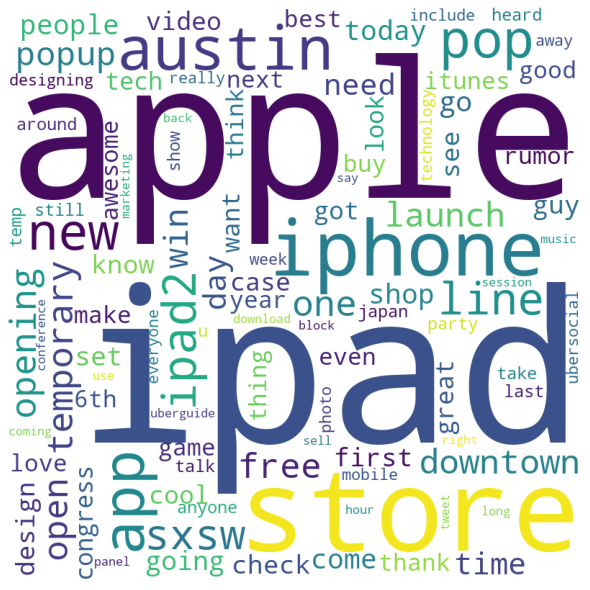

Hello World


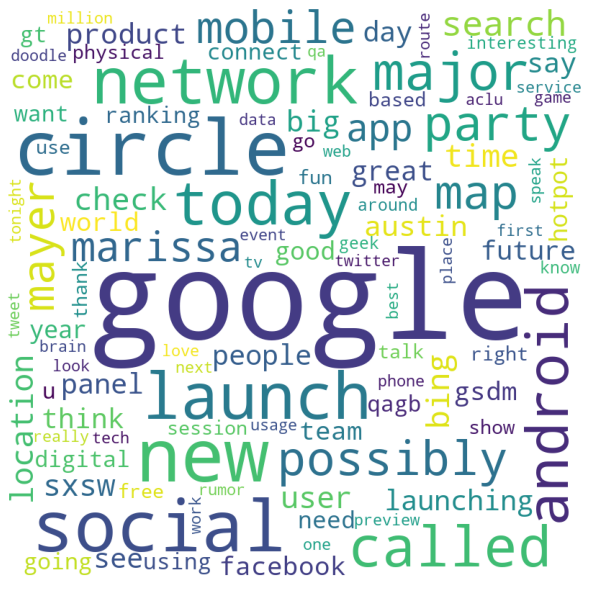

In [229]:
df['text'] = df['text'].apply(clean_text)
Apple = df[df['Apple']]
Apple = Apple.drop(Apple[Apple['Apple'] == False].index)

Google = df[df['Google']]
Google = Google.drop(Google[Google['Google'] == False].index)

Tweet_Apple = ' '.join(Apple['text'])
Tweet_Google = ' '.join(Google['text'])

Apple_Cloud = WordCloud(width=800, height=800, background_color='white', colormap='viridis', max_words=100, collocations=False).generate(Tweet_Apple)
Google_Cloud = WordCloud(width=800, height=800, background_color='white', colormap='viridis', max_words=100, collocations=False).generate(Tweet_Google)


plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(Apple_Cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

print('Hello World')

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(Google_Cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()